In [24]:
from PIL import Image
import piexif
import overpy
import os
import pandas as pd

In [9]:
def get_decimal_from_dms(dms, ref):
    degrees, minutes, seconds = dms
    decimal = degrees[0] / degrees[1] + \
              minutes[0] / minutes[1] / 60 + \
              seconds[0] / seconds[1] / 3600
    if ref in ['S', 'W']:
        decimal = -decimal
    return decimal

def extract_gps_info(img):
    try:
        exif_data = piexif.load(img.info['exif'])

        gps_info = exif_data.get('GPS')
        if not gps_info:
            return "No GPS info found in the image."

        gps_latitude = gps_info[piexif.GPSIFD.GPSLatitude]
        gps_latitude_ref = gps_info[piexif.GPSIFD.GPSLatitudeRef].decode()
        gps_longitude = gps_info[piexif.GPSIFD.GPSLongitude]
        gps_longitude_ref = gps_info[piexif.GPSIFD.GPSLongitudeRef].decode()

        lat = get_decimal_from_dms(gps_latitude, gps_latitude_ref)
        lon = get_decimal_from_dms(gps_longitude, gps_longitude_ref)

        return lat, lon

    except Exception as e:
        return f"Error: {e}"


In [12]:
api = overpy.Overpass()
def get_all_nearby_osm_objects(lat, lon, radius=50):
    """
    Get all OSM objects (nodes and ways) with tags near a location.
    """
    query = f"""
    (
      node(around:{radius},{lat},{lon})[~"."~"."];
      way(around:{radius},{lat},{lon})[~"."~"."];
    );
    out center;
    """
    try:
        result = api.query(query)
        objects = []

        for element in result.nodes + result.ways:
            name = element.tags.get("name", "Unnamed")
            objects.append({
                "name": name,
                "type": element.__class__.__name__.lower(),
                "tags": element.tags
            })

        return objects if objects else ["No objects found nearby."]
    except Exception as e:
        return [f"Error: {e}"]

In [29]:
import requests

def get_location_info(lat, lon, user_agent="my_location_app"):
    """
    Returns location information for the given latitude and longitude using OpenStreetMap's Nominatim API.

    Args:
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.
        user_agent (str): User-Agent string to identify the application (required by Nominatim).

    Returns:
        dict: A dictionary containing location details like address, display_name, etc.
    """
    url = "https://nominatim.openstreetmap.org/reverse"
    params = {
        "lat": lat,
        "lon": lon,
        "format": "json",
        "addressdetails": 1
    }
    headers = {
        "User-Agent": user_agent
    }

    response = requests.get(url, params=params, headers=headers)
    response.raise_for_status()  # Raise error for bad responses

    return response.json()

get_location_info(50.04765833333333, 19.938005555555556)

{'place_id': 170556609,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 203994757,
 'lat': '50.0479178',
 'lon': '19.9383259',
 'class': 'leisure',
 'type': 'garden',
 'place_rank': 30,
 'importance': 7.936751354233642e-05,
 'addresstype': 'leisure',
 'name': '',
 'display_name': 'Skałeczna, Kazimierz, Stare Miasto, Kraków, województwo małopolskie, 31-064, Polska',
 'address': {'road': 'Skałeczna',
  'quarter': 'Kazimierz',
  'suburb': 'Stare Miasto',
  'city_district': 'Stare Miasto',
  'city': 'Kraków',
  'state': 'województwo małopolskie',
  'ISO3166-2-lvl4': 'PL-12',
  'postcode': '31-064',
  'country': 'Polska',
  'country_code': 'pl'},
 'boundingbox': ['50.0473250', '50.0483319', '19.9375014', '19.9389094']}

In [42]:
def get_nearby_places(lat, lon, radius=100, user_agent="my_location_app"):
    """
    Get nearby amenities or points of interest from OpenStreetMap using the Overpass API.

    Args:
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.
        radius (int): Search radius in meters.
        user_agent (str): User-Agent string for headers.

    Returns:
        list of dict: List of nearby places with name, type, and coordinates.
    """
    overpass_url = "https://overpass-api.de/api/interpreter"
    headers = {
        "User-Agent": user_agent
    }

    # Overpass QL query to search for amenities (like restaurant, museum, etc.)
    query = f"""
    [out:json];
    (
      node(around:{radius},{lat},{lon})[amenity];
      way(around:{radius},{lat},{lon})[amenity];
      relation(around:{radius},{lat},{lon})[amenity];
    );
    out center;
    """

    response = requests.post(overpass_url, data=query, headers=headers)
    response.raise_for_status()
    data = response.json()

    places = []
    for element in data.get("elements", []):
        tags = element.get("tags", {})
        name = tags.get("name", "Unnamed")
        amenity_type = tags.get("amenity", "unknown")
        lat = element.get("lat") or element.get("center", {}).get("lat")
        lon = element.get("lon") or element.get("center", {}).get("lon")
        places.append({
            "name": name,
            "type": amenity_type,
            "latitude": lat,
            "longitude": lon
        })

    return places

get_nearby_places(*df['geo'][4],5500)

[{'name': 'Unnamed',
  'type': 'parking',
  'latitude': 50.0987991,
  'longitude': 19.8038207},
 {'name': 'Źródło w Dolinie Grzybowskiej',
  'type': 'drinking_water',
  'latitude': 50.1006103,
  'longitude': 19.784618},
 {'name': 'Unnamed',
  'type': 'parking',
  'latitude': 50.0901744,
  'longitude': 19.6871007},
 {'name': 'OSP Zabierzów',
  'type': 'fire_station',
  'latitude': 50.1131127,
  'longitude': 19.8037791},
 {'name': 'Unnamed',
  'type': 'parking',
  'latitude': 50.0864772,
  'longitude': 19.7916917},
 {'name': 'Unnamed',
  'type': 'parking',
  'latitude': 50.0866783,
  'longitude': 19.7851019},
 {'name': 'Urząd Pocztowy',
  'type': 'post_office',
  'latitude': 50.0879225,
  'longitude': 19.789774},
 {'name': 'Unnamed',
  'type': 'parking',
  'latitude': 50.0871674,
  'longitude': 19.7856543},
 {'name': 'Unnamed',
  'type': 'parking',
  'latitude': 50.0865261,
  'longitude': 19.7871381},
 {'name': 'Komenda Policji',
  'type': 'police',
  'latitude': 50.116155,
  'longitude'

In [33]:
def annotate_photo_location(lat, lon, radius=30, user_agent="photo_annotator"):
    """
    Attempts to annotate a photo taken at a GPS location with the most semantically relevant place.
    """
    overpass_url = "https://overpass-api.de/api/interpreter"
    headers = {"User-Agent": user_agent}

    # Query for enclosing building or amenity areas
    query = f"""
    [out:json];
    (
      way(around:{radius},{lat},{lon})[building];
      way(around:{radius},{lat},{lon})[amenity];
      relation(around:{radius},{lat},{lon})[building];
      relation(around:{radius},{lat},{lon})[amenity];
    );
    out center tags;
    """

    response = requests.post(overpass_url, data=query, headers=headers)
    response.raise_for_status()
    elements = response.json().get("elements", [])

    # Rank and choose the most likely candidate
    priority_tags = ['church', 'museum', 'temple', 'school', 'hospital', 'theatre', 'cathedral']
    best_match = None

    for elem in elements:
        tags = elem.get("tags", {})
        name = tags.get("name")
        building = tags.get("building")
        amenity = tags.get("amenity")

        place_type = amenity or building
        if not place_type:
            continue

        entry = {
            "name": name or "Unnamed",
            "type": place_type,
            "tags": tags
        }

        # Boost if it's a known semantic place type
        if place_type in priority_tags:
            return entry  # early return for high-priority match
        if not best_match:
            best_match = entry

    return best_match or {"name": "Unknown location", "type": "unknown"}

annotate_photo_location(50.04765833333333, 19.938005555555556, radius=100)

{'name': 'Kościół pw. Świętego Michała Archanioła i Świętego Stanisława Biskupa',
 'type': 'place_of_worship',
 'tags': {'addr:city': 'Kraków',
  'addr:housenumber': '15',
  'addr:postcode': '31-064',
  'addr:street': 'Skałeczna',
  'alt_name': 'Bazylika pw. Świętego Michała Archanioła i Świętego Stanislawa Biskupa',
  'amenity': 'place_of_worship',
  'building': 'church',
  'by:religious_title': 'papież Jan Paweł II',
  'church:type': 'parish',
  'date:religious_title': '2004-02-22',
  'deanery': 'Dekanat Kraków-Kazimierz',
  'denomination': 'roman_catholic',
  'diocese': 'Archidiecezja krakowska',
  'heritage': '2',
  'heritage:operator': 'nid',
  'historic': 'church',
  'loc_name': 'Kościół na Skałce',
  'name': 'Kościół pw. Świętego Michała Archanioła i Świętego Stanisława Biskupa',
  'name:hu': 'Szent Mihály arkangyal és Szent Stanisław püspök templom',
  'name:ru': 'Костёл на Скалке',
  'operator': 'Zakon Świętego Pawła Pierwszego Pustelnika',
  'ref:ckkp': 'MA00819',
  'ref:nid'

In [ ]:
im_dir = '../data/'

image_names = os.listdir(im_dir)

df = {'image': [], 'geo': [], 'osm':[]}

for image_name in image_names:
    if not ('jpg' in image_name.lower() or 'jpeg' in image_name.lower()):
        continue
    image = Image.open(im_dir+'/'+image_name)
    gps_output = extract_gps_info(image)
    if type(gps_output) == str:
        print(gps_output)
        continue
    else:
        lat, lon = gps_output
    osm_info = annotate_photo_location(lat,lon,100)
    df['image'].append(image)
    df['geo'].append((lat,lon))
    df['osm'].append(osm_info)


In [47]:
df['osm']

[{'name': 'Kościół pw. Świętego Michała Archanioła i Świętego Stanisława Biskupa',
  'type': 'place_of_worship',
  'tags': {'addr:city': 'Kraków',
   'addr:housenumber': '15',
   'addr:postcode': '31-064',
   'addr:street': 'Skałeczna',
   'alt_name': 'Bazylika pw. Świętego Michała Archanioła i Świętego Stanislawa Biskupa',
   'amenity': 'place_of_worship',
   'building': 'church',
   'by:religious_title': 'papież Jan Paweł II',
   'church:type': 'parish',
   'date:religious_title': '2004-02-22',
   'deanery': 'Dekanat Kraków-Kazimierz',
   'denomination': 'roman_catholic',
   'diocese': 'Archidiecezja krakowska',
   'heritage': '2',
   'heritage:operator': 'nid',
   'historic': 'church',
   'loc_name': 'Kościół na Skałce',
   'name': 'Kościół pw. Świętego Michała Archanioła i Świętego Stanisława Biskupa',
   'name:hu': 'Szent Mihály arkangyal és Szent Stanisław püspök templom',
   'name:ru': 'Костёл на Скалке',
   'operator': 'Zakon Świętego Pawła Pierwszego Pustelnika',
   'ref:ckkp'

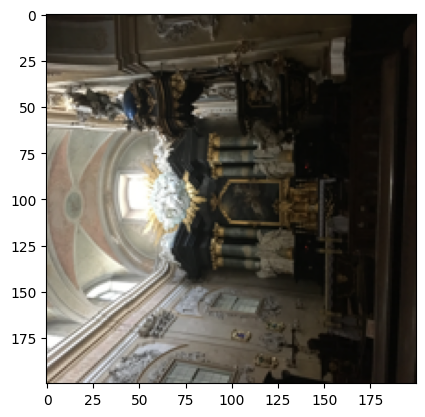

{'name': 'Kościół pw. Świętego Michała Archanioła i Świętego Stanisława Biskupa', 'type': 'place_of_worship', 'tags': {'addr:city': 'Kraków', 'addr:housenumber': '15', 'addr:postcode': '31-064', 'addr:street': 'Skałeczna', 'alt_name': 'Bazylika pw. Świętego Michała Archanioła i Świętego Stanislawa Biskupa', 'amenity': 'place_of_worship', 'building': 'church', 'by:religious_title': 'papież Jan Paweł II', 'church:type': 'parish', 'date:religious_title': '2004-02-22', 'deanery': 'Dekanat Kraków-Kazimierz', 'denomination': 'roman_catholic', 'diocese': 'Archidiecezja krakowska', 'heritage': '2', 'heritage:operator': 'nid', 'historic': 'church', 'loc_name': 'Kościół na Skałce', 'name': 'Kościół pw. Świętego Michała Archanioła i Świętego Stanisława Biskupa', 'name:hu': 'Szent Mihály arkangyal és Szent Stanisław püspök templom', 'name:ru': 'Костёл на Скалке', 'operator': 'Zakon Świętego Pawła Pierwszego Pustelnika', 'ref:ckkp': 'MA00819', 'ref:nid': 'A-29', 'religion': 'christian', 'religious_

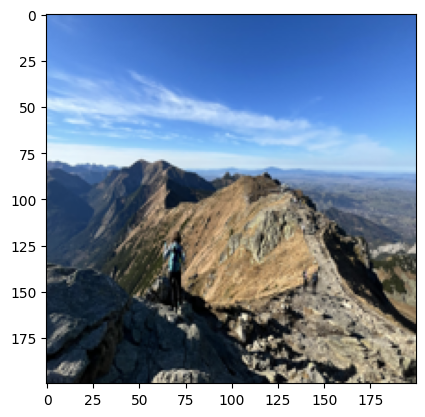

{'name': 'Unknown location', 'type': 'unknown'}


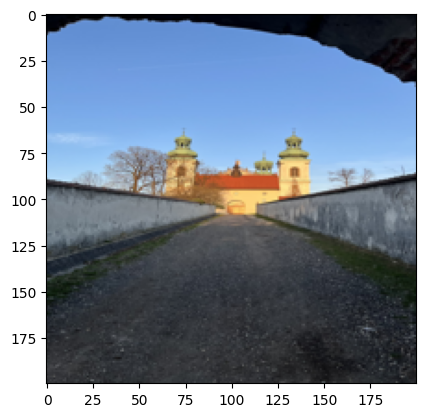

{'name': 'Zespół klasztorny Ojców Kamedułów na Bielanach', 'type': 'monastery', 'tags': {'amenity': 'monastery', 'community': 'ErCam', 'community:gender': 'male', 'community:pl': 'Kameduli', 'denomination': 'roman_catholic', 'landuse': 'religious', 'name': 'Zespół klasztorny Ojców Kamedułów na Bielanach', 'ref:ckkp': 'MA00783', 'religion': 'christian'}}


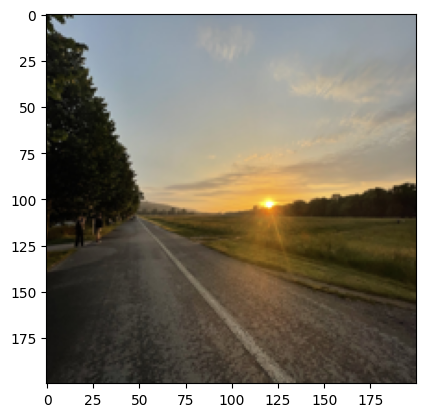

{'name': 'Unnamed', 'type': 'office', 'tags': {'addr:city': 'Kraków', 'addr:country': 'PL', 'addr:housenumber': '36', 'addr:postcode': '30-110', 'addr:street': 'Józefa Ignacego Kraszewskiego', 'building': 'office', 'building:levels': '4', 'source:building': 'BDOT', 'source:geometry': 'EGiB'}}


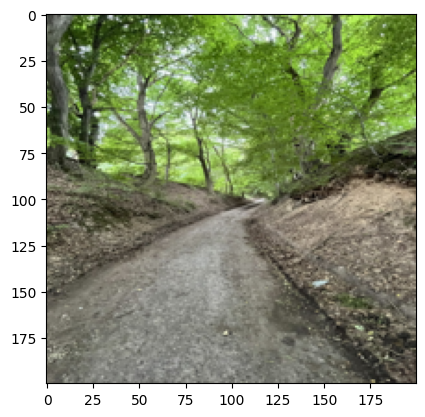

{'name': 'Unnamed', 'type': 'yes', 'tags': {'addr:city:simc': '0343770', 'addr:housenumber': '127', 'addr:place': 'Kleszczów', 'addr:postcode': '32-084', 'building': 'yes', 'source:addr': 'emuia.gugik.gov.pl'}}


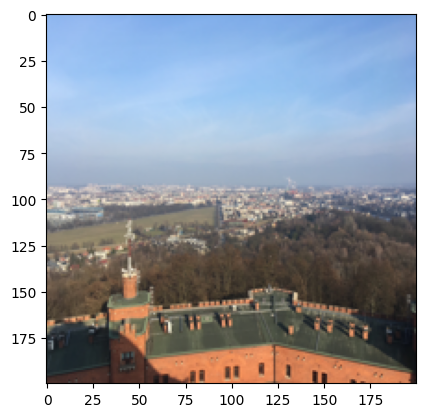

{'name': 'Koszary', 'type': 'yes', 'tags': {'addr:city': 'Kraków', 'addr:housenumber': '1', 'addr:postcode': '30-204', 'addr:street': 'Aleja Jerzego Waszyngtona', 'building': 'yes', 'name': 'Koszary'}}


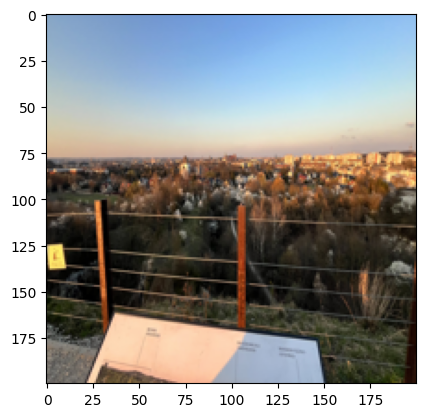

{'name': 'Unknown location', 'type': 'unknown'}


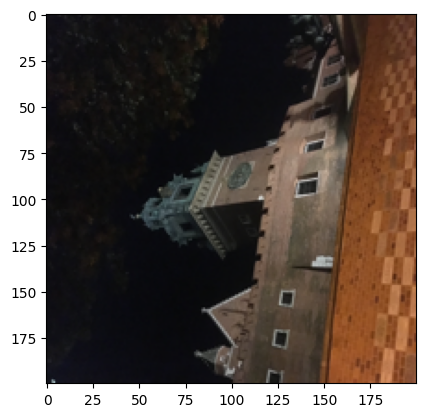

{'name': 'Unnamed', 'type': 'church', 'tags': {'building': 'church', 'source': 'Knowledge, Geoportal'}}


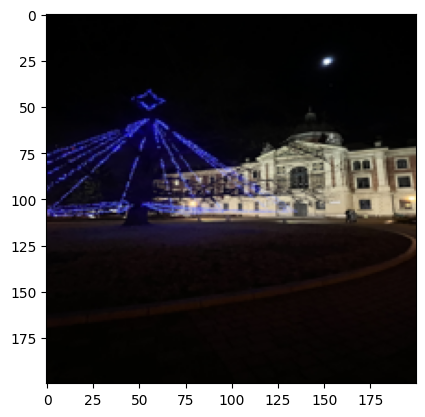

{'name': 'Unnamed', 'type': 'school', 'tags': {'addr:city': 'Kraków', 'addr:housenumber': '27', 'addr:postcode': '31-510', 'addr:street': 'Rakowicka', 'building': 'school'}}


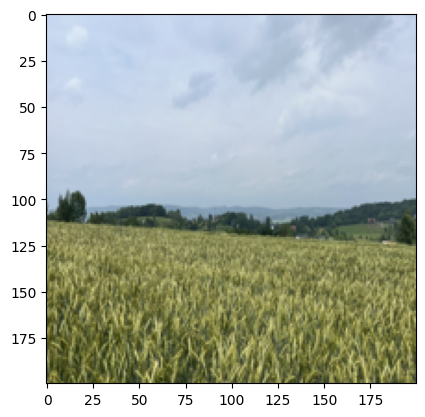

{'name': 'Unnamed', 'type': 'school', 'tags': {'addr:city': 'Brzoskwinia', 'addr:city:simc': '0343674', 'addr:housenumber': '7', 'addr:postcode': '32-084', 'addr:street': 'Tadeusza Skołuby', 'addr:street:sym_ul': '55754', 'building': 'school', 'source:addr': 'emuia.gugik.gov.pl'}}


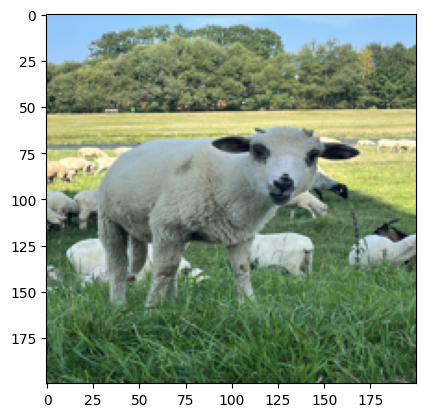

{'name': 'Unnamed', 'type': 'yes', 'tags': {'building': 'yes'}}


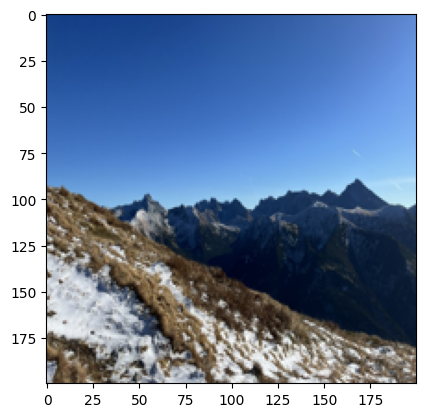

{'name': 'Unknown location', 'type': 'unknown'}


In [56]:
import matplotlib.pyplot as plt
import numpy as np
for i in range(len(df['image'])):
    plt.imshow(df['image'][i].resize((200,200)))
    plt.show()
    print(df['osm'][i])

In [59]:
import pickle
with open('../data/processed/df_01.pkl', 'wb') as f:
    pickle.dump(df, f)